In [6]:
from dask.distributed import Client, LocalCluster
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm
from IPython import display
import importlib
import utils
import velocity_helpers

In [29]:
import importlib
importlib.reload(velocity_helpers)

<module 'velocity_helpers' from 'c:\\Users\\s1759665\\OneDrive - University of Edinburgh\\paper2\\src\\velocity_helpers.py'>

In [8]:
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [31]:
## read in lines; lazily get velocity cubes, centrelines, and robust trends
lines = gpd.read_file('../data/streams_v2.geojson')
V = {}
failed = []
for row in tqdm(lines.sample(1).itertuples()):
    print(f'working on #{row.Index}')
    # try:
    V[row.Index] = velocity_helpers.CentreLiner(
        geo=row.geometry,
        buff_dist=3_000,
        index=row.Index,
        filter_cube=False,
        get_robust_trend=True,
        get_annual_median=False,
        sample_centreline=False,
        get_rgb=False,
        **{'ddt_range': ('335d', '395d'),
            'robust_trend_export': True})
        # display.clear_output(wait=True)
    # except Exception as e:
    #     failed.append((row.Index, e))
    #     print(f'#{row.Index} did not work because\n{e}')
    #     continue


0it [00:00, ?it/s]

working on #10
getting cubes from itslive
computing spatial trends


1it [7:31:38, 27098.13s/it]


In [33]:
old = xr.open_dataset(
    '../results/intermediate/velocity/robust_annual_trends/id10.zarr/',
    engine='zarr'
)
new = xr.open_dataset(
    '../results/intermediate/velocity/robust_annual_trends/240524_2312_id10.zarr/',
    engine='zarr')



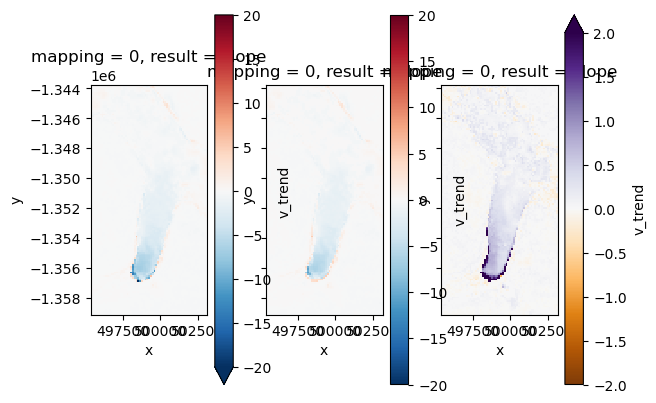

In [41]:
fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, subplot_kw={'aspect':'equal'})

old['v_trend'][:,:,0].plot(ax=axs[0], vmin=-20, vmax=20, cmap='RdBu_r')
new['v_trend'][:,:,0].plot(ax=axs[1], vmin=-20, vmax=20, cmap='RdBu_r')
(new['v_trend'][:,:,0] - old['v_trend'][:,:,0]).plot(ax=axs[2], vmin=-2, vmax=2, cmap='PuOr')

In [ ]:

# compute robust trends and export at the same time
for k, v in tqdm(V.items()):
    v.robust_trend['v_trend'].attrs = {'crs':3413,
                                       'buffer':3000,
                                       'ddt_range': v.ddt_range,
                                       'mad_n': v.n,
                                       'date':str(pd.Timestamp.now()),
                                       'centreline':v.tidy_stream.wkt,
                                       'centreline_id': k}
    
    (v.robust_trend['v_trend']
     .chunk(dict(zip(v.robust_trend['v_trend'].dims,
                    v.robust_trend['v_trend'].shape)))
     .to_zarr(f'../results/intermediate/velocity/robust_annual_trends/id{k}.zarr')
     )


In [2]:
import pandas as pd

In [5]:
pd.Timestamp.now().strftime('%Y%m%d_%H%M')

'20240524_1732'

In [1]:
pd.Timestamp.now()now = pd.Timestamp.now().strftime('%y%m%d_%H%M')+ '_'
directory = ''
filename = '.png'
fig.savefig(directory + now + filename, bbox_inches = 'tight')

NameError: name 'pd' is not defined

# plotting

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [3]:
lines = gpd.read_file('../data/streams_v2.geojson')

In [7]:
files = glob('../results/intermediate/velocity/robust_annual_trends/*.zarr')
dss = [xr.open_dataset(f, engine='zarr')['v_trend'] for f in files]

In [13]:
ids = [ds.attrs['centreline_id'] for ds in dss]

In [16]:
results= dict(zip(ids, dss))

In [23]:
from shapely import wkt

In [34]:
results.keys()

dict_keys([0, 1, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8])

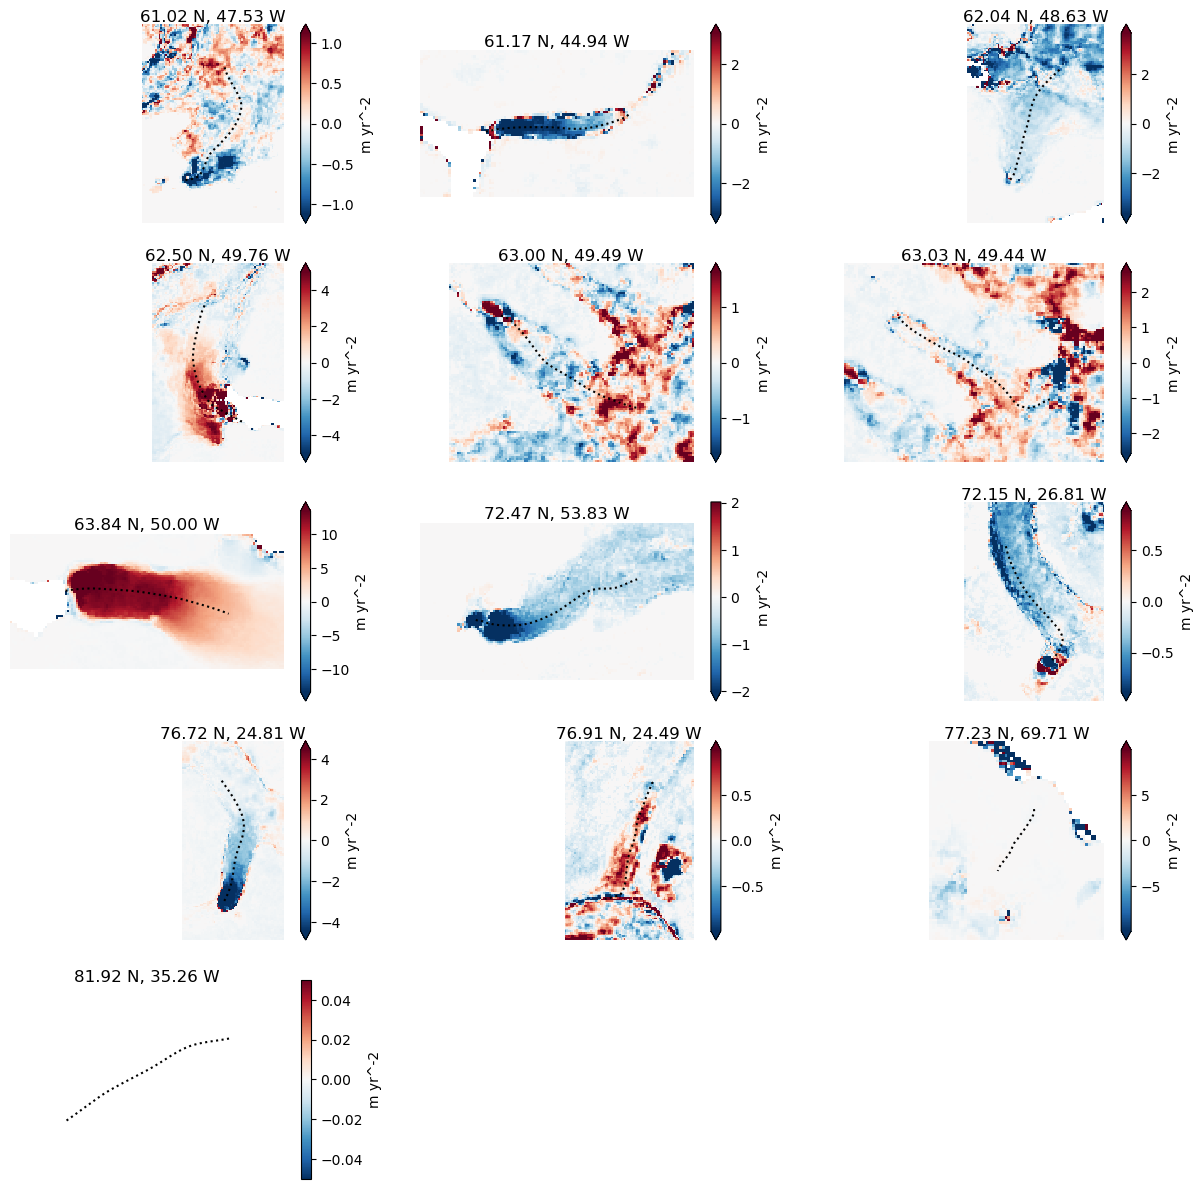

In [69]:
fig, axs = plt.subplots(ncols=3,
                        nrows=5,
                        subplot_kw={'aspect':'equal'},
                        figsize=[15,15])

# for k, v in results.items():
i = 0
for row in lines.itertuples(): 
    try:
        v = results[row.Index]
    except KeyError:
        continue
    
    v[:,:,0].plot(ax=axs.flat[i], robust=True, cmap='RdBu_r', cbar_kwargs={'label':'m yr^-2'})    
    _p = utils.shapely_reprojector(row.geometry.boundary.geoms[0])
    axs.flat[i].set_title(f'{_p.y:.2f} N, {-_p.x:.2f} W', y=0.97)
    axs.flat[i].plot(*row.geometry.coords.xy, c='k', ls=':')
    axs.flat[i].set_axis_off()
    i += 1

[ax.remove() for ax in axs.flat[-2:]]
# [axs.flat[q].remove() for q in [i for i in range(len(axs.flat)) if i not in results.keys()]]
fig.savefig('../results/intermediate/velocity/robust_annual_trends/spatial_plot.png')

now = pd.Timestamp.now().strftime('%y%m%d_%H%M')+ '_'
directory = '../../GitHub/diary/journal_figures/'
filename = 'robust_annual_trends_spatial_plot.png'
fig.savefig(directory + now + filename, bbox_inches = 'tight')

In [66]:
import os
os.getcwd()

'c:\\Users\\s1759665\\OneDrive - University of Edinburgh\\paper2\\src'

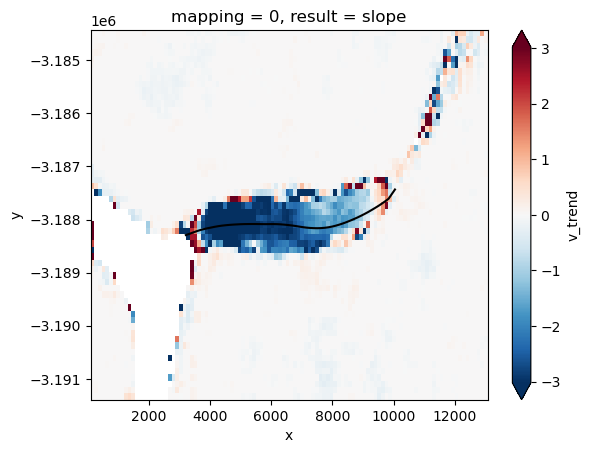

In [29]:
fig, axs = plt.subplots(ncols=3, nrows=5)

ls = wkt.loads(results[1].attrs['centreline'])
ax.plot(*ls.coords.xy, c='k')